# Plot Figures S.1 and S.3

In [1]:
import logging
import numpy
from matplotlib import pyplot
import pycbc
from pycbc.inference import io, models
from pycbc import detector

In [2]:
dirname = '../posteriors/agnostic/'
ftmplt = 'AGNOSTIC-{:02d}MS.hdf'
fn = dirname + ftmplt.format(0)
print(fn)

../posteriors/agnostic/AGNOSTIC-00MS.hdf


In [3]:
# load the model
logging.info("Setting up the model")
with io.loadfile(fn, 'r') as fp:
    data = fp.read_data()
    psds = fp.read_psds()
    cp = fp.read_config_file()
    samples = fp.read_samples(list(fp['samples'].keys()))
idx = samples['loglikelihood'].argmax()
params = {p: samples[p][idx] for p in samples.fieldnames}

# map parameter names to match samples and config
params["logamp220"] = params["logamp_a"]
params["f_220"] = params["f_a"]
params["tau_220"] = params["tau_a"]
params["phi220"] = params["phi_a"]
params["pol220"] = params["psi_a"]
params["polnm220"] = params["psinm_a"]

params["amp110"] = params["amp_c"]
params["f_110"] = params["f_c"]
params["tau_110"] = params["tau_c"]
params["phi110"] = params["phi_c"]
params["pol110"] = params["psi_c"]
params["polnm110"] = params["psinm_c"]

params["amp310"] = params["amp_b"]
params["f_310"] = params["f_b"]
params["tau_310"] = params["tau_b"]
params["phi310"] = params["phi_b"]
params["pol310"] = params["psi_b"]
params["polnm310"] = params["psinm_b"]

del params["logamp_a"]
del params["f_a"]
del params["tau_a"]
del params["phi_a"]
del params["psi_a"]
del params["psinm_a"]
del params["amp_b"]
del params["f_b"]
del params["tau_b"]
del params["phi_b"]
del params["psi_b"]
del params["psinm_b"]
del params["amp_c"]
del params["f_c"]
del params["tau_c"]
del params["phi_c"]
del params["psi_c"]
del params["psinm_c"]

In [4]:
# get the reference times in each detector
tref = float(cp.get('static_params', 'tref'))
ra = float(cp.get('static_params', 'ra'))
dec = float(cp.get('static_params', 'dec'))
print('ra:', ra, 'dec:', dec)
det_tref = {}
for detname in ['H1', 'L1', 'V1']:
    det = detector.Detector(detname)
    det_tref[detname] = tref + det.time_delay_from_earth_center(ra, dec, tref)
    print(detname, det_tref[detname])

ra: 3.5 dec: 0.73
H1 1242442967.425897
L1 1242442967.4242728
V1 1242442967.4360764


### Figure S.1 right

In [5]:
# get onsource data
model = models.read_from_config(cp, data=data, psds=psds)
model.update(**params)
_ = model.loglikelihood
win = 0.2
onsource_data = model.get_data()
for det in onsource_data:
    onsource_data[det] *= model._invpsds[det]**0.5
onsource_gated_data = model.get_gated_data()
for det in onsource_gated_data:
    onsource_gated_data[det] *= model._invpsds[det]**0.5
onsource_td_data = {}
onsource_td_gated_data = {}
for det in onsource_data:
    d = onsource_data[det]
    d = d.to_timeseries().time_slice(det_tref[det]-win, det_tref[det]+win)
    onsource_td_data[det] = d
    onsource_data[det] = d
    # gated
    d = onsource_gated_data[det]
    d = d.to_timeseries().time_slice(det_tref[det]-win, det_tref[det]+win)
    onsource_td_gated_data[det] = d
    onsource_gated_data[det] = d.to_frequencyseries()

In [6]:
# get data 2s later
toff = tref + 1
det_toff = {det:det_tref[det]+1 for det in det_tref}
cp.set('static_params', 'tref', str(toff))
model = models.read_from_config(cp, data=data, psds=psds)
model.update(**params)
_ = model.loglikelihood
offsource_data = model.get_data()
for det in offsource_data:
    offsource_data[det] *= model._invpsds[det]**0.5
offsource_gated_data = model.get_gated_data()
for det in offsource_gated_data:
    offsource_gated_data[det] *= model._invpsds[det]**0.5
for det, d in offsource_gated_data.items():
    d = d.to_timeseries().time_slice(det_toff[det]-win, det_toff[det]+win)
    offsource_gated_data[det] = d.to_frequencyseries()

In [7]:
colors = {'H1': 'C3', 'L1': 'C0', 'V1': 'purple'}

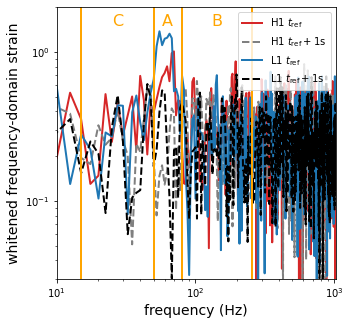

In [8]:
# plot
fig, ax = pyplot.subplots(figsize=(5,5)) 
ax.loglog()
ymin = 3e-2
ymax = 2
xmin = 10
xmax = 1024
offsource_colors = {'H1': 'gray', 'L1': 'black'}
for ii, det in enumerate(data.keys()):
    if det == 'V1':
        continue
    logging.info(det)
    x = onsource_gated_data[det]
    ax.plot(x.sample_frequencies, abs(x), lw=2, label=det+r' $t_{\rm ref}$',
            c=colors[det])
    x = offsource_gated_data[det]
    ax.plot(x.sample_frequencies, abs(x), lw=2, ls='--',
            c=offsource_colors[det],
            label=det+r' $t_{\rm ref} + 1$s')
binnames = 'CAB'
fbins = numpy.array([15, 50, 80, 256])
bincenter = 10**(numpy.log10(fbins)[:-1] + numpy.diff(numpy.log10(fbins))/2)
for ii, fbin in enumerate(fbins):
    ax.axvline(fbin, color='orange', lw=2, ls='-')
    if fbin < 256:
        ax.annotate(binnames[ii], xy=(bincenter[ii], 1.5), fontsize=16,
                    ha='center', color='orange')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# add the y label to the first axis
ax.set_ylabel(r"whitened frequency-domain strain", fontsize=14)
ax.set_xlabel("frequency (Hz)", fontsize=14)
# add the legend to the last axis
ax.legend(loc='upper right')

In [9]:
fig.savefig('fdomain_tref.pdf', dpi=200,bbox_inches='tight')

## Figure S.1 left

Text(0.01, 0.5, 'whitened gated strain')

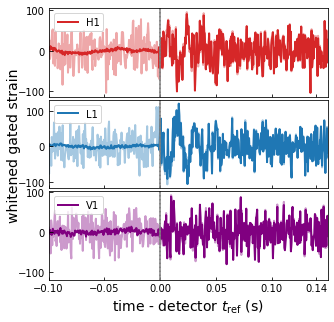

In [10]:
# time domain onsource
nrows = len(onsource_td_data.keys())
fig = pyplot.figure(figsize=(5, 5))
gs = fig.add_gridspec(nrows, 1, hspace=0.03)
for ii, det in enumerate(onsource_td_data):
    ax = pyplot.subplot(gs[ii])
    # original data
    data = onsource_td_data[det]
    ax.plot(data.sample_times-det_tref[det], data, lw=2, c=colors[det], alpha=0.4, zorder=0)
    # gated data
    data = onsource_td_gated_data[det]
    ax.plot(data.sample_times-det_tref[det], data, lw=2, c=colors[det], label=det, zorder=1)
    # add a line for the tref in the detector
    ax.axvline(det_tref[det]-det_tref[det], ls=':', color='gray')
    # add a line for the gate (which here is the same time)
    ax.axvline(det_tref[det]-det_tref[det], ls='-', color='gray')
    ax.set_xlim(-0.1, 0.15)
    ax.set_xticks([-0.1, -0.05, 0, 0.05,0.1,0.14])
    if ii != nrows-1:
        ax.set_xticklabels([])
    ax.legend(loc='upper left')
    ax.tick_params(axis="both", direction="in")
ax.set_xlabel(r'time - detector $t_{\rm ref}$ (s)', fontsize=14)
fig.text(0.01, 0.5, 'whitened gated strain', va='center', rotation='vertical',
         fontsize=14)

In [11]:
fig.savefig('tdomain_tref.pdf', dpi=200, bbox_inches='tight')

## Figure S.3

In [12]:
win = 0.2
toffset = 6

### 220

In [13]:
dirname = '../posteriors/kerr/220/'
ftmplt = 'KERR-220-{:02d}MS.hdf'
fn = dirname + ftmplt.format(toffset)
print(fn)

../posteriors/kerr/220/KERR-220-06MS.hdf


In [14]:
logging.info("Setting up the model")
with io.loadfile(fn, 'r') as fp:
    data = fp.read_data()
    psds = fp.read_psds()
    cp = fp.read_config_file()
    samples = fp.read_samples(list(fp['samples'].keys()))
idx = samples['loglikelihood'].argmax()
params = {p: samples[p][idx] for p in samples.fieldnames}

model = models.read_from_config(cp, data=data, psds=psds)
model.update(**params)
_ = model.loglikelihood
maxpol = model.current_stats['maxl_polarization']
params['polarization'] = maxpol

wf22 = model.get_gated_waveforms()
for det in wf22:
    Det = detector.Detector(det)
    ap = Det.antenna_pattern(model.current_params['ra'],
                             model.current_params['dec'],
                             maxpol,
                             model.current_params['tc'])
    wf22[det] = wf22[det][0] * ap[0] + wf22[det][1] * ap[1]
    wf22[det] *= model._invpsds[det]**0.5

td_wf22 = {}
for det, d in wf22.items():
    td_wf22[det] = wf22[det].to_timeseries().time_slice(det_tref[det]-win, det_tref[det]+win)

### 220 & 330

In [15]:
dirname = '../posteriors/kerr/220_330/'
ftmplt = 'KERR-220_330-{:02d}MS.hdf'
fn = dirname + ftmplt.format(toffset)
print(fn)

../posteriors/kerr/220_330/KERR-220_330-06MS.hdf


In [16]:
logging.info("Setting up the model")
with io.loadfile(fn, 'r') as fp:
    data = fp.read_data()
    psds = fp.read_psds()
    cp = fp.read_config_file()
    samples = fp.read_samples(list(fp['samples'].keys()))
idx = samples['loglikelihood'].argmax()
params = {p: samples[p][idx] for p in samples.fieldnames}

model = models.read_from_config(cp, data=data, psds=psds)
model.update(**params)
_ = model.loglikelihood
maxpol = model.current_stats['maxl_polarization']
data = model.get_gated_data()
for det in data:
    data[det] *= model._invpsds[det]**0.5
wf33 = model.get_gated_waveforms()
for det in wf33:
    Det = detector.Detector(det)
    ap = Det.antenna_pattern(model.current_params['ra'],
                             model.current_params['dec'],
                             maxpol,
                             model.current_params['tc'])
    wf33[det] = wf33[det][0] * ap[0] + wf33[det][1] * ap[1]
    wf33[det] *= model._invpsds[det]**0.5

td_data = {}
td_wf33 = {}
for det, d in wf33.items():
    td_wf33[det] = d.to_timeseries().time_slice(det_tref[det]-win, det_tref[det]+win)
    td_data[det] = data[det].to_timeseries().time_slice(det_tref[det]-win, det_tref[det]+win)

Text(0.01, 0.5, 'whitened gated strain')

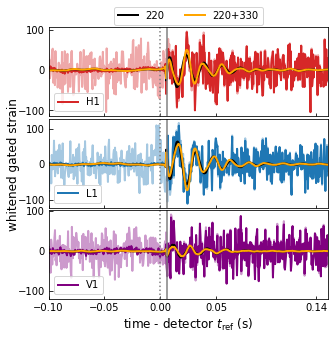

In [17]:
nrows = len(onsource_td_data.keys())
#fheight = nrows*2
fig = pyplot.figure(figsize=(5, 5))
gs = fig.add_gridspec(nrows, 1, hspace=0.03)
for ii, det in enumerate(td_data):
    ax = pyplot.subplot(gs[ii])
    # plot the original data
    data = onsource_td_data[det]
    ax.plot(data.sample_times-det_tref[det], data, lw=2, c=colors[det], alpha=0.4, zorder=0)
    # plot the gated data
    data = td_data[det]
    ax.plot(data.sample_times-det_tref[det], data, lw=2, c=colors[det], label=det)
    # plot the 220 waveform
    if ii == 0:
        lbl = '220'
    else:
        lbl = None
    wf = td_wf22[det]
    wf220, = ax.plot(wf.sample_times-det_tref[det], wf, lw=2, c='k')
    # now the 220 & 330
    if ii == 0:
        lbl = '220+330'
    else:
        lbl = None
    wf = td_wf33[det]
    wf220_330, = ax.plot(wf.sample_times-det_tref[det], wf, lw=2, c='orange')
    # add a line for the tref in the detector
    ax.axvline(det_tref[det]-det_tref[det], ls=':', color='gray')
    leg2 = ax.legend([wf220, wf220_330],['220','220+330'], bbox_to_anchor=(0., 1.02, 1., .21), loc='upper center',
           ncol=2,  borderaxespad=0.)
    if ii == 0:
        ax.add_artist(leg2)
    # add a line for the gate
    ax.axvline(toffset/1000., ls='-', color='gray')
    ax.set_xlim(-0.1, 0.15)
    ax.set_xticks([-0.1, -0.05, 0, 0.05, 0.14])
    if ii != nrows-1:
        ax.set_xticklabels([])
    ax.legend(loc='lower left')
    ax.tick_params(axis="both", direction="in")
ax.set_xlabel(r'time - detector $t_{\rm ref}$ (s)', fontsize=12)
fig.text(0.01, 0.5, 'whitened gated strain', va='center', rotation='vertical',
         fontsize=12)

In [18]:
fig.savefig('tdomain_maxl-{}ms.pdf'.format(toffset), dpi=200, bbox_inches='tight')